# AirBnB New York Data Analysis and Price Forecast

üß∏ Hi there, We are TEAM `coffee prince`. We do analysis with this AirBnB Dataset.  
This notebook contains EDA and Feature Engineering.   
We only do feature engineering for name column.  

Our feature engineering code contains only name. 

## 00. Library

EDA Predicts Price After Feature Engineering Using Boosting Family Models 'LightGBM', 'XGBoost' and 'CatBoost'

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV 


## Visualization Initialization

In [2]:
# Define the base color (Airbnb-like color)
base_color = "#FF5733"

# Create a gradient color palette with 10 colors
grad_palette = sns.light_palette(base_color, n_colors=10, input="hex", reverse=True)

# Set the Seaborn style and custom gradient color palette
sns.set(style="whitegrid")
sns.set_palette(grad_palette)

## 01. EDA

- **id** : id value of hosted house 
   - Based on Airbnb accommodation inquiry
   - - https://www.airbnb.co.kr/rooms/{id}  
- **name** : Name introducing the hosted home 
   - a pretty house with a swimming pool
- **host_id**: id of the host 
- **host_name** : Name of the host
- **neighbourhood_group**: the area where the hosted home is located
- **neighbourhood**: Nomination around hosted home
- **latitude**: latitude
- **longitude**: hardness
- **room_type**: Type of hosted home
- **price**: Daily accommodation price (target variable)
- **minimum_nights**: Minimum number of nights 
 - **number_of_reviews** : Total number of reviews 
- **last_review**: Last review date
- **reviews_per_month**: number of reviews per month 
- **calculated_host_listings_count**: Number of accommodations hosted by the host 
- **availability_365**: number of days 
- **number_of_reviews_ltm**: Number of reviews in the last n months 
- **license**: Accommodation License
    - 'Special': Only one person has a license

In [6]:
# df = pd.read_csv('/kaggle/input/new-york-city-airbnb-2023-public-data/NYC-Airbnb-2023.csv')
df = pd.read_csv('../NYC-Airbnb-2023.csv')

/var/folders/qm/t7nj8jrn23q1bgrhrz17cyhh0000gn/T/ipykernel_11056/3949286476.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../NYC-Airbnb-2023.csv')


In [7]:
df.head(3)

id                                name  host_id  host_name  \
0  2595               Skylit Midtown Castle     2845   Jennifer   
1  5121                     BlissArtsSpace!     7356      Garon   
2  5203  Cozy Clean Guest Room - Family Apt     7490  MaryEllen   

  neighbourhood_group       neighbourhood  latitude  longitude  \
0           Manhattan             Midtown  40.75356  -73.98559   
1            Brooklyn  Bedford-Stuyvesant  40.68535  -73.95512   
2           Manhattan     Upper West Side  40.80380  -73.96751   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0  Entire home/apt    150              30                 49  2022-06-21   
1     Private room     60              30                 50  2019-12-02   
2     Private room     75               2                118  2017-07-21   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0               0.30                               3               314   
1               0.30                               2               365   
2               0.72                               1                 0   

   number_of_reviews_ltm license  
0                      1     NaN  
1                      0     NaN  
2                      0     NaN

**Check the NULL ratio**
- **name**: approximately 2% no accommodation name
-  **host_name** : approximately 1%
- **last_review, reviews_per_month**: 24% of accommodations without reviews
-  **license** : 99.9% 
    - Only one license is available

In [8]:
columns = df.columns
total_rows = df.shape[0]

for c in columns:
    null_count = df[c].isnull().sum()
    null_ratio = round((null_count / total_rows) * 100, 2)
    print(f"null ratio of {c}: {null_ratio}%")

null ratio of id: 0.0%
null ratio of name: 0.03%
null ratio of host_id: 0.0%
null ratio of host_name: 0.01%
null ratio of neighbourhood_group: 0.0%
null ratio of neighbourhood: 0.0%
null ratio of latitude: 0.0%
null ratio of longitude: 0.0%
null ratio of room_type: 0.0%
null ratio of price: 0.0%
null ratio of minimum_nights: 0.0%
null ratio of number_of_reviews: 0.0%
null ratio of last_review: 24.0%
null ratio of reviews_per_month: 24.0%
null ratio of calculated_host_listings_count: 0.0%
null ratio of availability_365: 0.0%
null ratio of number_of_reviews_ltm: 0.0%
null ratio of license: 100.0%


**Check technical statistics**
- Range of values such as num_of_reviews, minimum_nights, etc. is wide  
Consider reducing deviations with ${\rightarrow}$ Scaling

In [9]:
df.describe()

id       host_id      latitude     longitude         price  \
count  4.293100e+04  4.293100e+04  42931.000000  42931.000000  42931.000000   
mean   2.222772e+17  1.516012e+08     40.728273    -73.943665    200.307167   
std    3.344213e+17  1.621301e+08      0.057640      0.056627    895.082911   
min    2.595000e+03  1.678000e+03     40.500314    -74.251907      0.000000   
25%    1.940474e+07  1.608533e+07     40.687485    -73.981750     75.000000   
50%    4.337482e+07  7.433812e+07     40.724040    -73.952620    125.000000   
75%    6.305016e+17  2.680692e+08     40.762293    -73.924035    200.000000   
max    8.404660e+17  5.038729e+08     40.911380    -73.710870  99000.000000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count    42931.000000       42931.000000       32627.000000   
mean        18.111178          25.856001           1.168988   
std         27.462513          56.616344           1.789675   
min          1.000000           0.000000           0.010000   
25%          2.000000           1.000000           0.140000   
50%          7.000000           5.000000           0.520000   
75%         30.000000          24.000000           1.670000   
max       1250.000000        1842.000000          86.610000   

       calculated_host_listings_count  availability_365  number_of_reviews_ltm  
count                    42931.000000      42931.000000           42931.000000  
mean                        24.054809        140.262211               7.736507  
std                         80.867958        142.001486              18.290256  
min                          1.000000          0.000000               0.000000  
25%                          1.000000          0.000000               0.000000  
50%                          1.000000         89.000000               0.000000  
75%                          4.000000        289.000000               7.000000  
max                        526.000000        365.000000            1093.000000

In [10]:
def show_bar_plot(df:pd.DataFrame, features:list , y: str, oriend_c_num:int=2):
    
    """
    A function that draws a bar plot after calculating the count by group based on the features in features
    """

    # Define the base color (Airbnb-like color)
    base_color = "#FF5A5F"

    # Create a gradient color palette with 10 colors
    grad_palette = sns.light_palette(base_color, n_colors=10, input="hex", reverse=True)

    # Set the Seaborn style and custom gradient color palette
    sns.set(style="whitegrid", palette=grad_palette)
    
    
    r_num = len(features) // oriend_c_num 
    c_num = oriend_c_num
    
    
    fig, axes = plt.subplots(r_num, c_num, figsize=(10, 5))

    for i, x in enumerate(features):
        
        row = i // c_num
        col = i % c_num
        cnt_df = df.groupby(x).count()[y].reset_index()
        ax = axes[row][col] if r_num > 1 else axes[col]

        sns.barplot(data = cnt_df,x = x, y = y, ax=ax) #, palette = ""

        # Adding labels and title
        plt.xlabel(x)
        plt.ylabel('Count')
        plt.title(f'Number of {y} by {x}')

        # Rotating x-axis labels if needed
        plt.xticks()
    plt.tight_layout()
    # Displaying the graph
    plt.show()

**neighbourhood_group**  
5 groups exist and Manhattan has the most 


**room_type**  
Fewer Hotel Rooms and Sahred Rooms  
${\rightarrow}$Low number of Hotel Rooms and high price range

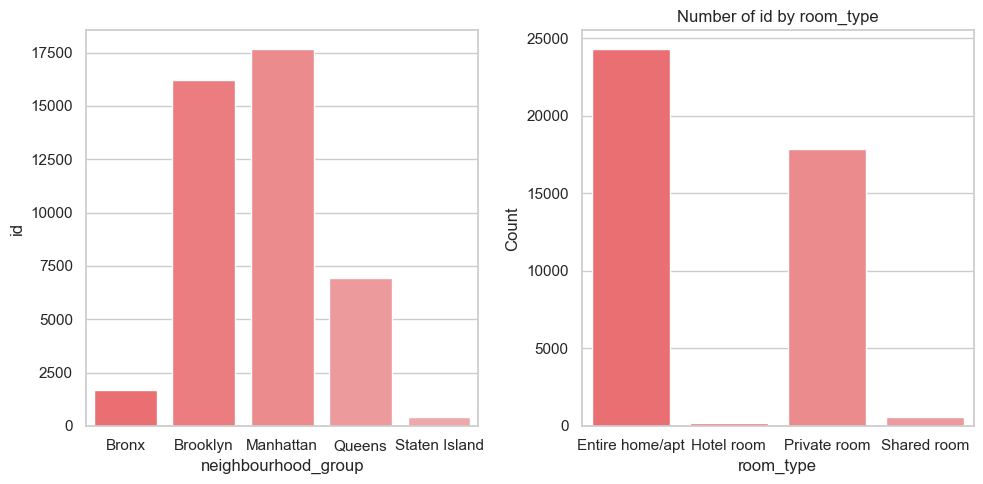

In [11]:
show_bar_plot(df,features =[ 'neighbourhood_group', 'room_type'],y = 'id')

**Check the number of reviews**
- Mostly zero reviews, only a few properties have a high number of reviews

In [12]:
review_num_count = df.groupby('number_of_reviews_ltm').count()['id'].reset_index()

In [13]:
review_num_count.sort_values('id', ascending=False)

number_of_reviews_ltm     id
0                        0  21470
1                        1   3377
2                        2   2238
3                        3   1711
4                        4   1226
..                     ...    ...
135                    158      1
136                    162      1
137                    164      1
138                    171      1
167                   1093      1

[168 rows x 2 columns]

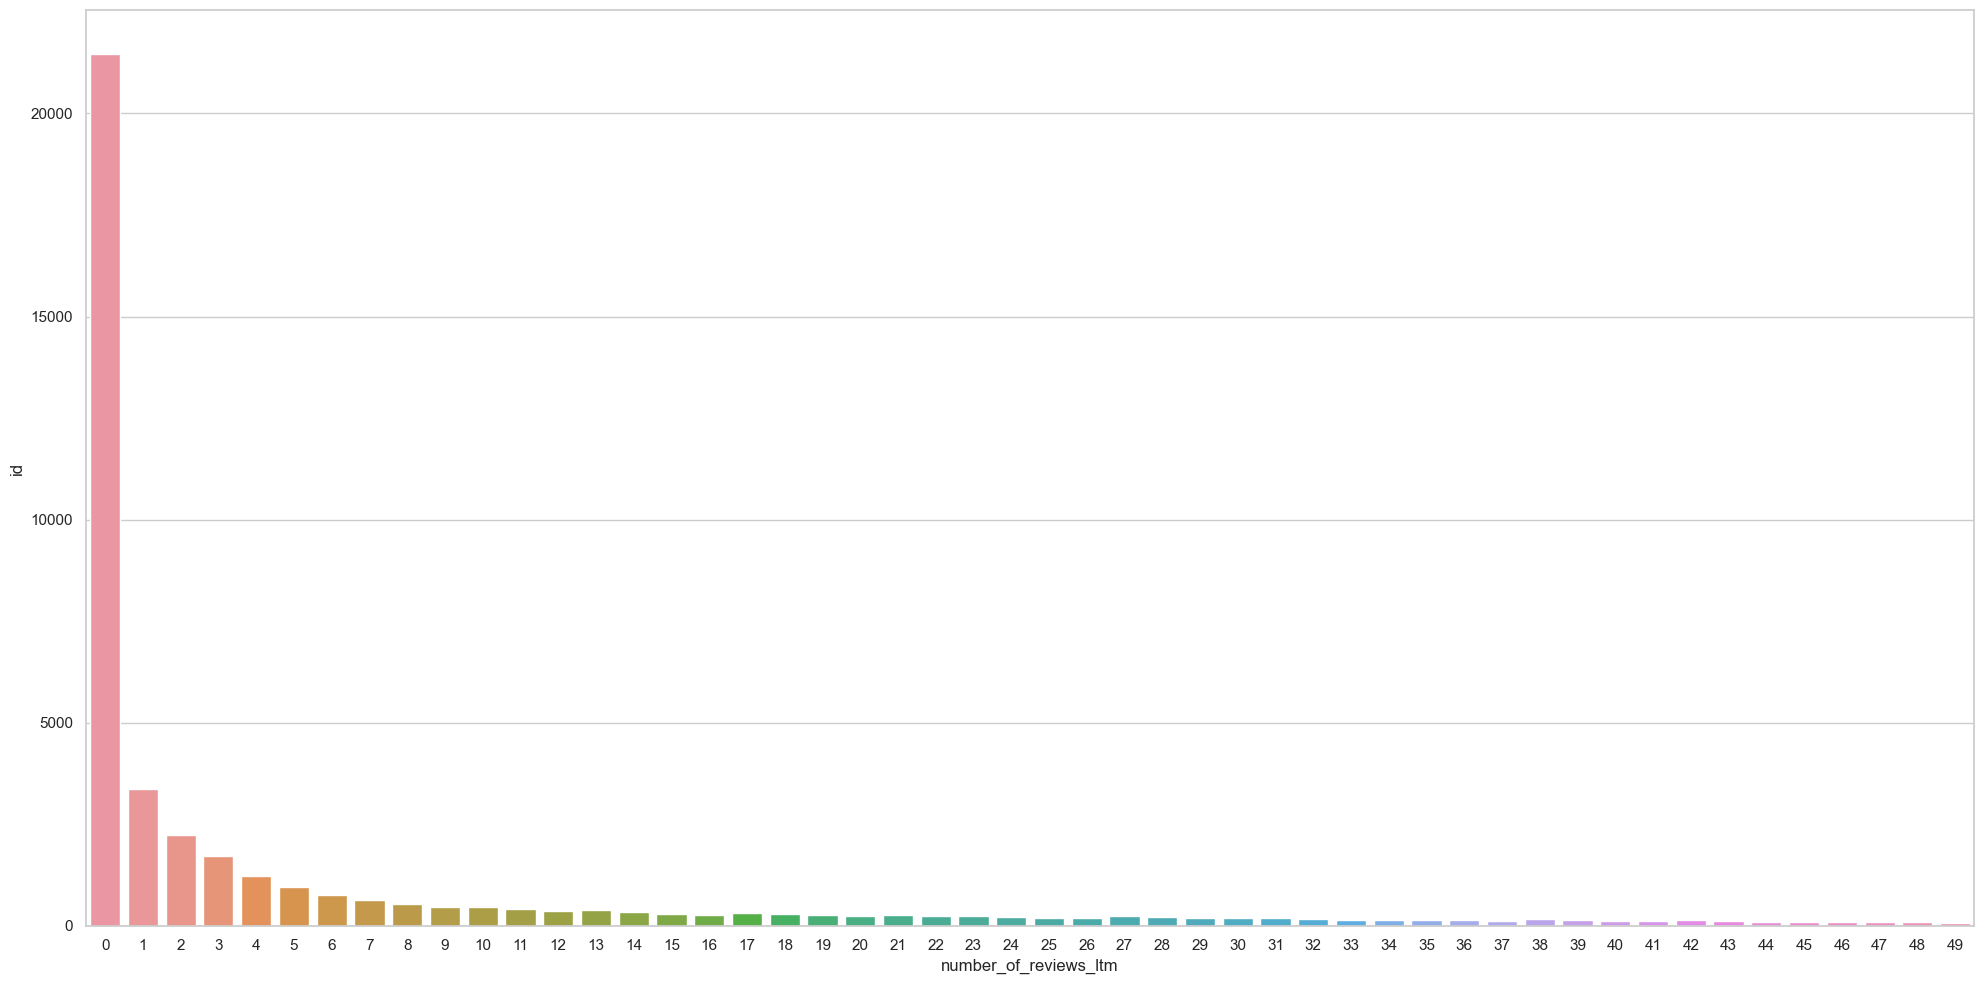

In [14]:
plt.figure(figsize=(20,10))

sns.barplot(data=review_num_count[:50], x='number_of_reviews_ltm', y='id')

plt.tight_layout()

**Check the number of houses hosted**

In [15]:
df['calculated_host_listings_count'].unique()

array([  3,   2,   1,   4,   5,  30,   9,   6,   7,  10,  12,   8,  17,
        15,  19,  29, 159,  38,  28,  31,  62,  57,  51, 207,  33,  14,
       131, 124,  11, 113,  16,  23,  83, 526, 394, 192, 178,  76,  18,
        13,  63,  36,  24,  54,  48, 222,  88, 101,  27,  47,  25,  32,
        59,  53,  21,  22,  44,  20,  35,  41,  39, 120, 107,  69, 356])

**Check correlation**
- 'Note' id and target variable do not check correlation 'priority'
   - Host id is treated as an interval variable because it is related to the status, location, etc. of the house hosted by host  
  - Number_of_reviews, reviews_per_month, and number_of_review_itm are highly correlated, so two must be removed

In [16]:
def show_heatmap_with_corr(df:pd.DataFrame , drop_column:str=['id', 'latitude', 'longitude', 'price']):
    # Create a correlation matrix
    # Show up to the second decimal place
#     # Define the base color (Airbnb-like color)
#     base_color = "#FF5A5F"

#     # Create a gradient color palette with 10 colors
#     grad_palette = sns.light_palette(base_color, n_colors=100, input="hex", reverse=True)

#     # Set the Seaborn style and custom gradient color palette
#     sns.set(style="whitegrid", palette=grad_palette)
    
    try :
        corr_df = df.drop(drop_column, axis = 1)
    except : 
        print("The column to remove does not already exist in the dataframe.")
    else:
        correlation_matrix = corr_df.corr().round(2)

        # Specifying Image Size
        plt.figure(figsize=(20,10))

        # Show Correlation Matrix
        sns.heatmap(data=correlation_matrix, annot=True, cmap = "Reds_r")

/var/folders/qm/t7nj8jrn23q1bgrhrz17cyhh0000gn/T/ipykernel_11056/3310868678.py:18: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = corr_df.corr().round(2)


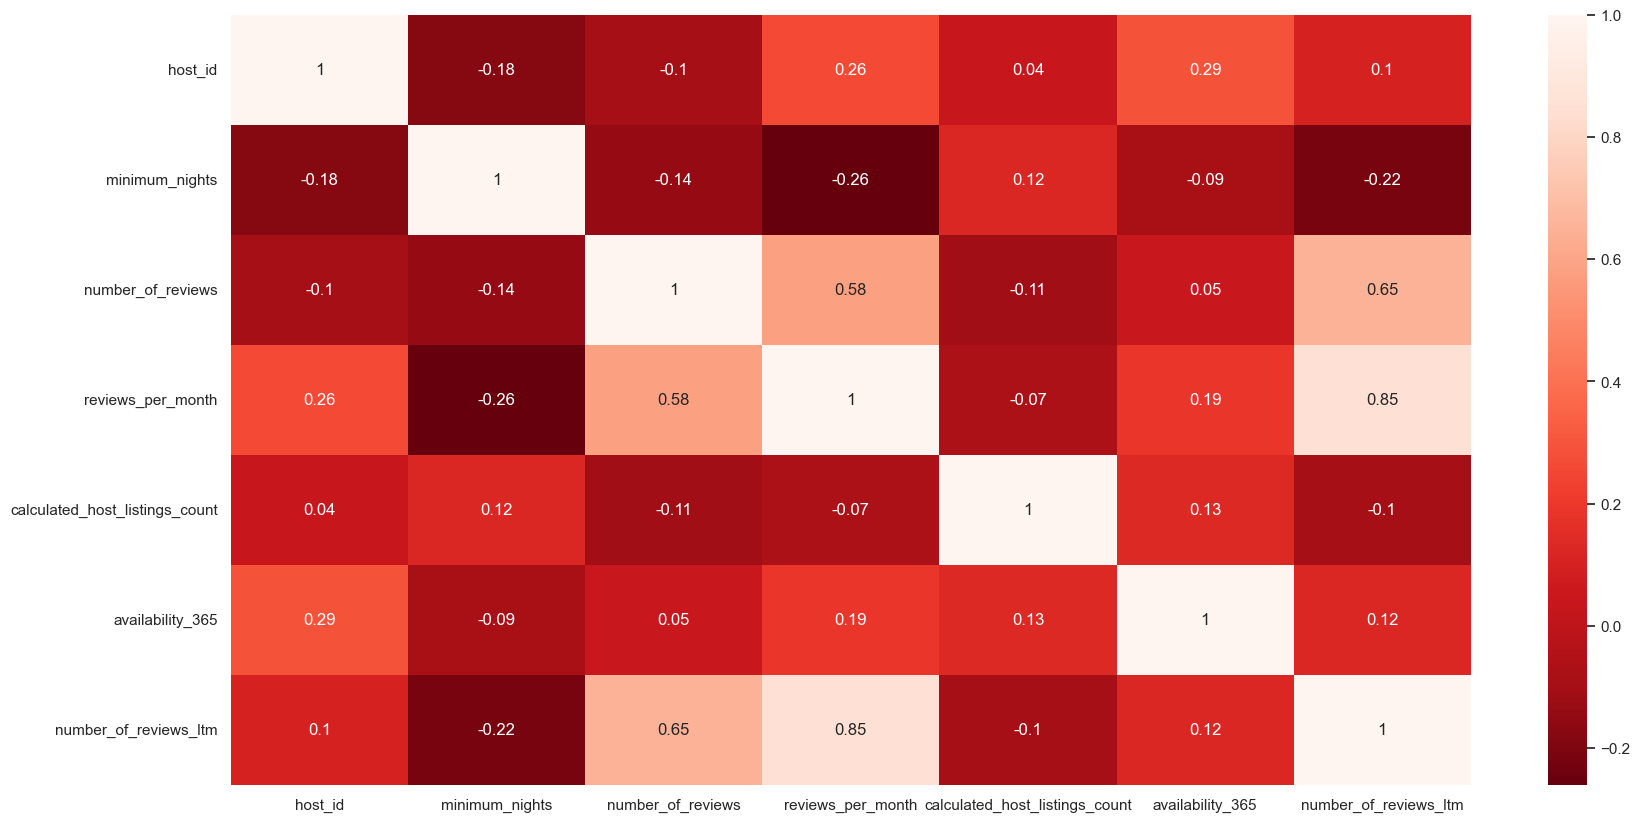

In [17]:
show_heatmap_with_corr(df)

In [18]:
# Number by host id (=number of hosting houses)
df.groupby('host_id')['id'].count().sort_values( ascending=False)[:10].reset_index()

host_id   id
0  107434423  526
1    3223938  394
2  496944100  356
3  305240193  222
4   19303369  207
5  200239515  192
6  204704622  178
7  162280872  159
8   51501835  131
9   61391963  124

**Which home did the person who hosted the most homes host?**
- Keywords such as gym and pool exist

In [19]:
df[df['host_id'] == 107434423].head(2)

id                                      name    host_id  \
11486  20845031  Midtown E. 1BR w/ Gym, Doorman, nr the 6  107434423   
12885  23264421   Midtown E. 1BR w/ Gym, nr Grand Central  107434423   

        host_name neighbourhood_group neighbourhood   latitude  longitude  \
11486  Blueground           Manhattan      Kips Bay  40.745723 -73.979862   
12885  Blueground           Manhattan   Murray Hill  40.748405 -73.979865   

             room_type  price  minimum_nights  number_of_reviews last_review  \
11486  Entire home/apt    386              31                  0         NaN   
12885  Entire home/apt    538              31                  0         NaN   

       reviews_per_month  calculated_host_listings_count  availability_365  \
11486                NaN                             526               216   
12885                NaN                             526                 0   

       number_of_reviews_ltm license  
11486                      0     NaN  
12885                      0     NaN

In [20]:
df[df['host_id'] == 107434423]['name'].unique()

array(['Midtown E. 1BR w/ Gym, Doorman, nr the 6',
       'Midtown E. 1BR w/ Gym, nr Grand Central',
       'Park Avenue 1BR w/ Gym, Doorman in Midtown',
       'Tribeca 1BR w/ Gym, Doorman & Roof deck',
       'Winged Tribeca Studio w/ Indoor pool, Gym',
       'UES Studio w/ Balcony, Gym & Doorman',
       '1BR nr Times Sq w/ Indoor pool & Gym',
       'Tribeca Studio w/ Great views & Indoor pool',
       'E. Village 1BR, Gym, Doorman, Rooftop',
       'UWS 1BR w/ Stunning Gym, Doorman & Rooftop',
       'Chelsea 1BR w/ Balcony, Doorman & Gym',
       'UWS 1BR w/ Open kitchen, Doorman & Gym',
       'Wall St 1BR w/ Gym, Doorman, Roof deck',
       'UES 1BR w/Doorman 15m nr Central Park',
       'Wall St 1BR w/Speakeasy, Doorman & Gym',
       'Studio in Trendy Tribeca, Indoor pool & Gym',
       'Central W. Village 1BR, Gym, Doorman',
       'Charismatic 1BR in W. Village w/ Doorman & Gym',
       'Sq 1BR w/ Great views & Indoor pool',
       '2BR nr Times Sq w/ Indoor pool & Gym',
 

In [21]:
# 444 except for those with the same dorm name
df[df['host_id'] == 107434423]['name'].nunique()

444

In [22]:
# Days Available
df['availability_365'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [23]:
# Verifying Licenses
df[~df['license'].isnull()]

id                          name    host_id host_name  \
10101  17984049  Apartamento Algarve Holidays  120181746    Isabel   

      neighbourhood_group      neighbourhood  latitude  longitude  \
10101           Manhattan  Flatiron District  40.74075  -73.98902   

             room_type  price  minimum_nights  number_of_reviews last_review  \
10101  Entire home/apt    133              30                  1  2017-07-19   

       reviews_per_month  calculated_host_listings_count  availability_365  \
10101               0.01                               1               126   

       number_of_reviews_ltm   license  
10101                      0  41662/AL

**Check the columns to be used**

- [ ] **id** : id value of hosted house 
   - Based on Airbnb accommodation inquiry
   - - https://www.airbnb.co.kr/rooms/{id}  
- [x] **name** : Name introducing the hosted home 
   - a pretty house with a swimming pool
- [x] **host_id** : id of the host 
- [x] **host_name** : Name of the host
- [x] **neighbourhood_group** : The area where the hosted home is located
- [ ] **neighbourhood**: Names around hosted homes
- [ ] **latitude**: latitude
- [ ] **longitude: hardness
- [x] **room_type** : Type of hosted house
- [x] **price** : Daily accommodation price (target variable)
- - [x] **minimum_nights** : Minimum number of nights to stay 
- [x] **number_of_reviews** : Total number of reviews 
- [x] **last_review** : Last review date
- [x] **reviews_per_month**: number of reviews per month 
- [x] **calculated_host_listings_count**: Number of accommodations hosted by the host 
- [x] **availability_365** : Days Available 
- [x] **number_of_reviews_ltm**: Number of reviews in the last n months 
- [ ] **license**: Accommodation license
    - 'Special': Only one person has a license

In [24]:
use_columns = ['id',  # id for data verification, removed during train 
               'name', 
               'host_id', 
               'neighbourhood_group',
               'neighbourhood', 
               'room_type',
               'price', 
               'minimum_nights', 
               'number_of_reviews', 
               'reviews_per_month', 
               'number_of_reviews_ltm', 
               'last_review', 
               'calculated_host_listings_count', 
               'availability_365']

In [25]:
train_df = df[use_columns]

In [26]:
# Remove column with null name 
train_df = train_df.dropna(subset = ['name'])

In [27]:
# Convert all names to lowercase
train_df['ext_opt'] = train_df['name'].str.lower()

In [28]:
# null check
train_df['ext_opt'].isna().sum()

0

In [29]:
# Option mapping part: Annotate specific options only for use
# train_df = train_df['ext_opt'].apply(get_options) 

In [30]:
lst = ["gym", "pool", "beach", "view", "park", "camping", "skiing", "lake", "new", "surf"]

In [31]:
for item in lst:
    
    train_df[lst] = 0

In [32]:
train_df.head()

id                                         name  host_id  \
0  2595                        Skylit Midtown Castle     2845   
1  5121                              BlissArtsSpace!     7356   
2  5203           Cozy Clean Guest Room - Family Apt     7490   
3  5178             Large Furnished Room Near B'way„ÄÄ     8967   
4  5136  Large Sunny Brooklyn Duplex, Patio + Garden     7378   

  neighbourhood_group       neighbourhood        room_type  price  \
0           Manhattan             Midtown  Entire home/apt    150   
1            Brooklyn  Bedford-Stuyvesant     Private room     60   
2           Manhattan     Upper West Side     Private room     75   
3           Manhattan             Midtown     Private room     68   
4            Brooklyn         Sunset Park  Entire home/apt    275   

   minimum_nights  number_of_reviews  reviews_per_month  ...  gym pool  beach  \
0              30                 49               0.30  ...    0    0      0   
1              30                 50               0.30  ...    0    0      0   
2               2                118               0.72  ...    0    0      0   
3               2                575               3.41  ...    0    0      0   
4              60                  3               0.03  ...    0    0      0   

   view park  camping  skiing  lake  new  surf  
0     0    0        0       0     0    0     0  
1     0    0        0       0     0    0     0  
2     0    0        0       0     0    0     0  
3     0    0        0       0     0    0     0  
4     0    0        0       0     0    0     0  

[5 rows x 25 columns]


See which option was used in the title of a hosted car based on all options in the Airbnb filter

In [33]:
def get_option_compact(house_name:str):
    
    """
    Return house_name if it has the corresponding option by pasted option
    """
    
    opt = ""
    
    if( "gym" in house_name ): 
        opt += "gym "
    
    if( "pool" in house_name ): 
        opt += "pool "
    
    if( "view" in house_name ): 
        opt += "view "     
    
    if( "park" in house_name ): 
        opt += "park "
    
    if( "skiing" in house_name ): 
        opt += "skiing "

    if( "new" in house_name ): 
        opt += "new "     

    if( "bbq" in house_name ): 
        opt += "bbq "

#     if( "lake" in house_name ): 
#         opt += "lake "   

#     if( "camping" in house_name ): 
#         opt += "camping "
        
#     if( "surf" in house_name ): 
#         opt += "surfing "

#     if( "beach" in house_name ): 
#         opt += "beach "
    return opt[:-1] # Remove last space

In [34]:
train_df['ext_opt_new'] = train_df['ext_opt'].apply(get_option_compact)

In [35]:
train_df

id                                            name  \
0                    2595                           Skylit Midtown Castle   
1                    5121                                 BlissArtsSpace!   
2                    5203              Cozy Clean Guest Room - Family Apt   
3                    5178                Large Furnished Room Near B'way„ÄÄ   
4                    5136     Large Sunny Brooklyn Duplex, Patio + Garden   
...                   ...                                             ...   
42926  839753193689829909                   bright studio in Williamsburg   
42927  839786573617495393  Room in the heart of LES with Gym& Rooftop BBQ   
42928  839797749155954018                   Fantastic 3BD apt in Brooklyn   
42929  839814083143454171                                The Coziest Home   
42930  839817199240589949                                      378-2L-Red   

         host_id neighbourhood_group       neighbourhood        room_type  \
0           2845           Manhattan             Midtown  Entire home/apt   
1           7356            Brooklyn  Bedford-Stuyvesant     Private room   
2           7490           Manhattan     Upper West Side     Private room   
3           8967           Manhattan             Midtown     Private room   
4           7378            Brooklyn         Sunset Park  Entire home/apt   
...          ...                 ...                 ...              ...   
42926   28057253            Brooklyn        Williamsburg  Entire home/apt   
42927  247439246           Manhattan        East Village     Private room   
42928   26349246            Brooklyn            Bushwick  Entire home/apt   
42929   48533809       Staten Island         Bull's Head  Entire home/apt   
42930  488616033            Brooklyn        Williamsburg     Private room   

       price  minimum_nights  number_of_reviews  reviews_per_month  ...  pool  \
0        150              30                 49               0.30  ...     0   
1         60              30                 50               0.30  ...     0   
2         75               2                118               0.72  ...     0   
3         68               2                575               3.41  ...     0   
4        275              60                  3               0.03  ...     0   
...      ...             ...                ...                ...  ...   ...   
42926     76               7                  0                NaN  ...     0   
42927     32              30                  0                NaN  ...     0   
42928    127               3                  0                NaN  ...     0   
42929    280               1                  0                NaN  ...     0   
42930     78              90                  0                NaN  ...     0   

      beach  view  park camping  skiing  lake  new  surf  ext_opt_new  
0         0     0     0       0       0     0    0     0               
1         0     0     0       0       0     0    0     0               
2         0     0     0       0       0     0    0     0               
3         0     0     0       0       0     0    0     0               
4         0     0     0       0       0     0    0     0               
...     ...   ...   ...     ...     ...   ...  ...   ...          ...  
42926     0     0     0       0       0     0    0     0               
42927     0     0     0       0       0     0    0     0      gym bbq  
42928     0     0     0       0       0     0    0     0               
42929     0     0     0       0       0     0    0     0               
42930     0     0     0       0       0     0    0     0               

[42919 rows x 26 columns]

In [36]:
train_df.head(2)

id                   name  host_id neighbourhood_group  \
0  2595  Skylit Midtown Castle     2845           Manhattan   
1  5121        BlissArtsSpace!     7356            Brooklyn   

        neighbourhood        room_type  price  minimum_nights  \
0             Midtown  Entire home/apt    150              30   
1  Bedford-Stuyvesant     Private room     60              30   

   number_of_reviews  reviews_per_month  ...  pool beach  view  park camping  \
0                 49                0.3  ...     0     0     0     0       0   
1                 50                0.3  ...     0     0     0     0       0   

   skiing  lake  new  surf  ext_opt_new  
0       0     0    0     0               
1       0     0    0     0               

[2 rows x 26 columns]

In [37]:
for item in lst:
    
    train_df.loc[train_df['ext_opt_new']== item, item] = 1

In [38]:
ext_opt_cnt = train_df.groupby('ext_opt').count().reset_index()

In [39]:
train_df['ext_opt_cnt'] = 0 # column for checking the number of options in house_name

In [40]:
for l in lst:
    train_df.loc[ train_df['ext_opt'].str.contains(l),'ext_opt_cnt'] += 1

In [41]:
train_df.head(2)

id                   name  host_id neighbourhood_group  \
0  2595  Skylit Midtown Castle     2845           Manhattan   
1  5121        BlissArtsSpace!     7356            Brooklyn   

        neighbourhood        room_type  price  minimum_nights  \
0             Midtown  Entire home/apt    150              30   
1  Bedford-Stuyvesant     Private room     60              30   

   number_of_reviews  reviews_per_month  ...  beach view  park  camping  \
0                 49                0.3  ...      0    0     0        0   
1                 50                0.3  ...      0    0     0        0   

  skiing  lake  new  surf  ext_opt_new  ext_opt_cnt  
0      0     0    0     0                         0  
1      0     0    0     0                         0  

[2 rows x 27 columns]

**Process review date data**
- Convert to datetime type
- Year, month, and day
+ Need to see if prices vary by day of the week

In [42]:
train_df['last_review_dt'] = pd.to_datetime(train_df['last_review'])

In [43]:
train_df['last_review_year'] = train_df['last_review_dt'].dt.year

In [44]:
train_df[train_df['last_review_year'].isnull()]

id                                            name  \
15                  68253                    Room in the heart of Astoria   
47                  11943                       Country space in the city   
88                  45935                    Room in Beautiful Townhouse.   
101                 51438             1 Bedroom in 2 Bdrm Apt- Upper East   
114                 54466             Beautiful Uptown Manhattan apartmnt   
...                   ...                                             ...   
42926  839753193689829909                   bright studio in Williamsburg   
42927  839786573617495393  Room in the heart of LES with Gym& Rooftop BBQ   
42928  839797749155954018                   Fantastic 3BD apt in Brooklyn   
42929  839814083143454171                                The Coziest Home   
42930  839817199240589949                                      378-2L-Red   

         host_id neighbourhood_group    neighbourhood        room_type  price  \
15         67730              Queens          Astoria     Private room     55   
47         45445            Brooklyn         Flatbush     Private room    150   
88        204586               Bronx       Mott Haven     Private room     60   
101       236421           Manhattan  Upper East Side     Private room    130   
114       253385           Manhattan           Harlem     Private room    200   
...          ...                 ...              ...              ...    ...   
42926   28057253            Brooklyn     Williamsburg  Entire home/apt     76   
42927  247439246           Manhattan     East Village     Private room     32   
42928   26349246            Brooklyn         Bushwick  Entire home/apt    127   
42929   48533809       Staten Island      Bull's Head  Entire home/apt    280   
42930  488616033            Brooklyn     Williamsburg     Private room     78   

       minimum_nights  number_of_reviews  reviews_per_month  ...  park  \
15                 30                  0                NaN  ...     0   
47                 30                  0                NaN  ...     0   
88                 30                  0                NaN  ...     0   
101                14                  0                NaN  ...     0   
114                30                  0                NaN  ...     0   
...               ...                ...                ...  ...   ...   
42926               7                  0                NaN  ...     0   
42927              30                  0                NaN  ...     0   
42928               3                  0                NaN  ...     0   
42929               1                  0                NaN  ...     0   
42930              90                  0                NaN  ...     0   

      camping  skiing  lake new  surf  ext_opt_new  ext_opt_cnt  \
15          0       0     0   0     0                         0   
47          0       0     0   0     0                         0   
88          0       0     0   0     0                         0   
101         0       0     0   0     0                         0   
114         0       0     0   0     0                         0   
...       ...     ...   ...  ..   ...          ...          ...   
42926       0       0     0   0     0                         0   
42927       0       0     0   0     0      gym bbq            1   
42928       0       0     0   0     0                         0   
42929       0       0     0   0     0                         0   
42930       0       0     0   0     0                         0   

       last_review_dt  last_review_year  
15                NaT               NaN  
47                NaT               NaN  
88                NaT               NaN  
101               NaT               NaN  
114               NaT               NaN  
...               ...               ...  
42926             NaT               NaN  
42927             NaT               NaN  
42928             NaT               NaN  
42929      

In [45]:
# Label Encoder for Room Type
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_df['room_type'] )
train_df['room_type_le'] = le.transform(train_df['room_type'])

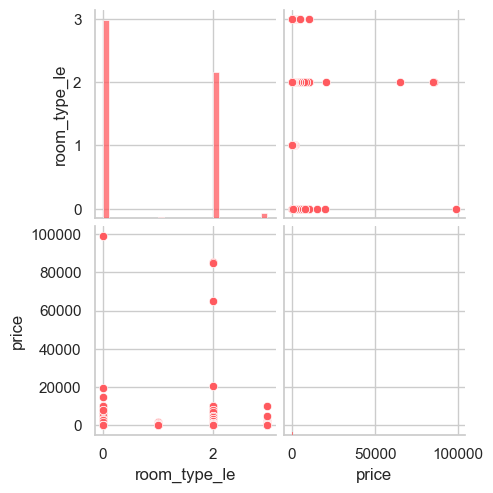

In [46]:
sns.pairplot(train_df[['room_type_le', 'price']])

In [47]:
le.inverse_transform([0, 1, 2, 3]) # Check the label encoder value

array(['Entire home/apt', 'Hotel room', 'Private room', 'Shared room'],
      dtype=object)

**Price check according to room_type**
- Hotel tends to be expensive
- Entier Home/apt needs to be checked for outliers


${\rightarrow}$ Remove price anomalies for the entire house 
- The reason for not dividing by group is that the number of specific labels is small

> If price is 0, it can be confirmed that availability_365 value is also 0
> - If the price is 0, you will notice that reservation is not possible 
> Remove if ${\Rightarrow}$ price is 0

In [48]:
train_df.groupby('room_type')['price'].agg(['median','mean','min', 'max', 'std','var'])

median        mean  min    max          std           var
room_type                                                                 
Entire home/apt   174.0  249.260155   10  99000   737.690299  5.441870e+05
Hotel room        240.0  309.959391    0   1592   284.291418  8.082161e+04
Private room       73.0  135.036592   10  85170  1081.075474  1.168724e+06
Shared room        56.0  126.243478   15  10000   497.519274  2.475254e+05

In [49]:
# Non-rentable house with a price of 0 
train_df[train_df['price']== 0 ].head(10)

id                                  name    host_id  \
19977  40560656  The Hoxton, Williamsburg - Cosy Room  273324213   
20459  41740615            The James New York - NoMad  268417148   
20460  41740622       Gardens Suites Hotel by Affinia  269311462   
20542  41792753                 Mint House At 70 Pine  197053492   
20718  42279171                        Leon Hotel LES  265458818   
20790  42065545                       Carvi Hotel NYC  310429455   
20791  42065547                          Hotel Five44  308721299   
20797  42065563                     Opera House Hotel  309772430   
20798  42065564                   The Wall Street Inn  314151200   
20823  42228997                  Sister City New York  314197504   

      neighbourhood_group       neighbourhood   room_type  price  \
19977            Brooklyn        Williamsburg  Hotel room      0   
20459           Manhattan             Midtown  Hotel room      0   
20460           Manhattan     Upper East Side  Hotel room      0   
20542           Manhattan  Financial District  Hotel room      0   
20718           Manhattan           Chinatown  Hotel room      0   
20790           Manhattan             Midtown  Hotel room      0   
20791           Manhattan      Hell's Kitchen  Hotel room      0   
20797               Bronx          Mott Haven  Hotel room      0   
20798           Manhattan  Financial District  Hotel room      0   
20823           Manhattan     Lower East Side  Hotel room      0   

       minimum_nights  number_of_reviews  reviews_per_month  ...  camping  \
19977               1                 83               1.98  ...        0   
20459               1                 48               1.18  ...        0   
20460               1                  5               0.15  ...        0   
20542               1                619              10.81  ...        0   
20718               1                348               8.05  ...        0   
20790              30                  0                NaN  ...        0   
20791              30                 43               1.44  ...        0   
20797              30                  0                NaN  ...        0   
20798               1                 51               1.59  ...        0   
20823              30                  0                NaN  ...        0   

      skiing  lake  new surf  ext_opt_new  ext_opt_cnt  last_review_dt  \
19977      0     0    0    0                         0      2023-02-17   
20459      0     0    1    0          new            1      2022-10-10   
20460      0     0    0    0                         0      2022-10-01   
20542      0     0    0    0                         0      2023-01-02   
20718      0     0    0    0                         0      2023-02-13   
20790      0     0    0    0                         0             NaT   
20791      0     0    0    0                         0      2023-02-05   
20797      0     0    0    0                         0             NaT   
20798      0     0    0    0                         0      2023-02-19   
20823      0     0    1    0          new            1             NaT   

       last_review_year  room_type_le  
19977            2023.0             1  
20459            2022.0             1  
20460            2022.0             1  
20542            2023.0             1  
20718            2023.0             1  
20790               NaN             1  
20791            2023.0             1  
20797               NaN             1  
20798            2023.0             1  
20823               NaN             1  

[10 rows x 30 columns]

In [50]:
train_df[train_df['price']==0]['availability_365'].unique()

array([0])

Will those with zero price have more reviews than others? 
- Fast-selling rooms tend to have a large number of reviews


In [51]:
train_df[train_df['price']==0][['number_of_reviews','reviews_per_month','number_of_reviews_ltm']].agg(['mean','max','min','std','var'])

number_of_reviews  reviews_per_month  number_of_reviews_ltm
mean          69.333333           2.586842              15.185185
max          619.000000          10.810000              79.000000
min            0.000000           0.050000               0.000000
std          134.547961           3.115777              23.424243
var        18103.153846           9.708067             548.695157

In [52]:
train_df[['number_of_reviews','reviews_per_month','number_of_reviews_ltm']].agg(['mean','max','min','std','var'])

number_of_reviews  reviews_per_month  number_of_reviews_ltm
mean          25.862439           1.169153               7.738671
max         1842.000000          86.610000            1093.000000
min            0.000000           0.010000               0.000000
std           56.622843           1.789762              18.292355
var         3206.146368           3.203246             334.610255

Classification ${\rightarrow}$ have_price column for rooms/no rooms  
- Do not use due to large differences in proportions

In [53]:
train_df['have_price'] = False

In [54]:
train_df.loc[train_df['price'] > 0 , 'have_price'] = True

In [55]:
train_df['have_price'].value_counts(dropna=False, normalize=True) 

True     0.999371
False    0.000629
Name: have_price, dtype: float64

In [56]:
train_df['have_price'].value_counts(dropna=False) 

True     42892
False       27
Name: have_price, dtype: int64

**Excluding data with a price value of 0**

In [57]:
train_df = train_df[train_df['price'] > 0]

In [58]:
train_df['price'].min()

10

In [59]:
train_df[['number_of_reviews','reviews_per_month','number_of_reviews_ltm']].agg(['mean','max','min','std','var'])

number_of_reviews  reviews_per_month  number_of_reviews_ltm
mean          25.835074           1.168327               7.733983
max         1842.000000          86.610000            1093.000000
min            0.000000           0.010000               0.000000
std           56.533180           1.788458              18.288066
var         3196.000404           3.198581             334.453353

In [60]:
train_df.head(2)

id                   name  host_id neighbourhood_group  \
0  2595  Skylit Midtown Castle     2845           Manhattan   
1  5121        BlissArtsSpace!     7356            Brooklyn   

        neighbourhood        room_type  price  minimum_nights  \
0             Midtown  Entire home/apt    150              30   
1  Bedford-Stuyvesant     Private room     60              30   

   number_of_reviews  reviews_per_month  ...  skiing lake  new  surf  \
0                 49                0.3  ...       0    0    0     0   
1                 50                0.3  ...       0    0    0     0   

  ext_opt_new  ext_opt_cnt  last_review_dt  last_review_year  room_type_le  \
0                        0      2022-06-21            2022.0             0   
1                        0      2019-12-02            2019.0             2   

   have_price  
0        True  
1        True  

[2 rows x 31 columns]

**Check the proportion of room_type by pie chart after excluding price of zero**

**Arithmetic data of non-zero price data**

In [61]:
train_df_rt_pr_describe = train_df.groupby('room_type')['price'].agg(['min', 'max', 'mean', 'median','std','var']).reset_index()

In [62]:
train_df_rt_pr_describe

room_type  min    max        mean  median          std           var
0  Entire home/apt   10  99000  249.260155   174.0   737.690299  5.441870e+05
1       Hotel room   99   1592  359.188235   254.5   275.584628  7.594689e+04
2     Private room   10  85170  135.036592    73.0  1081.075474  1.168724e+06
3      Shared room   15  10000  126.243478    56.0   497.519274  2.475254e+05

**Check box plot by room_type**
- Considering outliers by type ${\rightarrow}$ Rejected  
- Eliminate outliers to the entire data target due to the relatively small number of hotel rooms or shared rooms

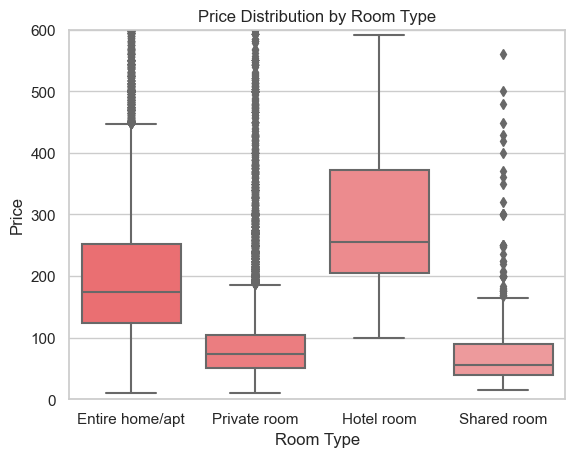

In [63]:
# Create price data frames by room type
room_type_price_df = train_df.groupby('room_type')['price'].median().reset_index()

# Draw a boxplot
sns.boxplot(data=train_df, x='room_type', y='price')

# Graph Title and Axis Label Settings
plt.title('Price Distribution by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.ylim(0, 600)

# Graph Output
plt.show()


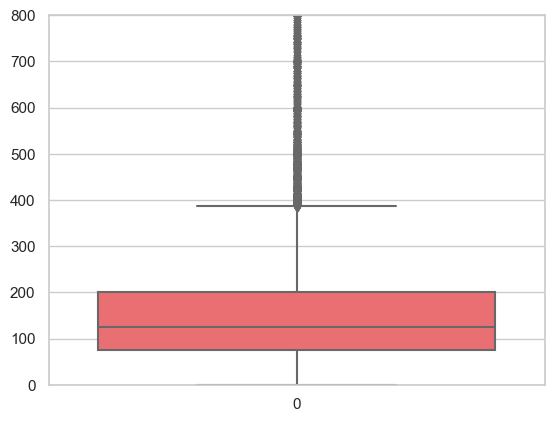

In [64]:
# Box plot for the entire price

sns.boxplot(df['price'])
plt.ylim(0, 800)
plt.show()

In [65]:
train_df['price'].mean()

200.4500139886226

In [66]:
train_df[train_df['price']==10].head(3)

id                                               name   host_id  \
10069  17952277  Newly renovated, fully furnished room in Brooklyn  62685070   
17204  34546192  Large, Sunny, Quiet  Room in Harlem, New York ...   1542506   
18775  38359468            1 Bedroom walking distance to UBS Arena  49494045   

      neighbourhood_group   neighbourhood        room_type  price  \
10069            Brooklyn        Bushwick     Private room     10   
17204           Manhattan          Harlem     Private room     10   
18775              Queens  Queens Village  Entire home/apt     10   

       minimum_nights  number_of_reviews  reviews_per_month  ...  skiing lake  \
10069              30                  0                NaN  ...       0    0   
17204              30                  4               0.09  ...       0    0   
18775              30                 10               0.24  ...       0    0   

       new  surf ext_opt_new  ext_opt_cnt  last_review_dt  last_review_year  \
10069    1     0         new            1             NaT               NaN   
17204    1     0         new            1      2019-09-16            2019.0   
18775    0     0                        0      2022-10-12            2022.0   

       room_type_le  have_price  
10069             2        True  
17204             2        True  
18775             0        True  

[3 rows x 31 columns]

In [67]:
# Date of most recently written date
train_df['last_review_dt'].max()

Timestamp('2023-03-06 00:00:00')

In [68]:
train_df[train_df['last_review_dt']=='2023-03-06']['id'].count()

26

**Check in descending order of price**

In [69]:
train_df['price'].sort_values(ascending=False)[:20]

34299    99000
32440    85170
34929    85100
9418     65115
9809     20500
31388    19750
33266    15000
18940    10000
19353    10000
27614    10000
2796     10000
8421     10000
18941    10000
12643    10000
18935    10000
16104    10000
42067     9999
36549     9999
3234      9999
21166     9999
Name: price, dtype: int64

In [70]:
# Checking Outliers 
train_df[train_df['price']==85170]

id                                               name  \
32440  638990296543110131  Groovy bedroom in BK next to METRO & Industry ...   

        host_id neighbourhood_group neighbourhood     room_type  price  \
32440  51913277            Brooklyn   Sunset Park  Private room  85170   

       minimum_nights  number_of_reviews  reviews_per_month  ...  skiing lake  \
32440               1                 38               4.52  ...       0    0   

       new  surf ext_opt_new  ext_opt_cnt  last_review_dt  last_review_year  \
32440    0     0                        0      2022-12-31            2022.0   

       room_type_le  have_price  
32440             2        True  

[1 rows x 31 columns]

In [71]:
# a house that is actually priced at $65  
train_df[train_df['price']==65115]

id                                             name   host_id  \
9418  16289102  Comfy private room, great location to Manhattan  92493393   

     neighbourhood_group  neighbourhood     room_type  price  minimum_nights  \
9418       Staten Island  West Brighton  Private room  65115               2   

      number_of_reviews  reviews_per_month  ...  skiing lake  new  surf  \
9418                 55               0.72  ...       0    0    0     0   

     ext_opt_new  ext_opt_cnt  last_review_dt  last_review_year  room_type_le  \
9418                        0      2022-07-29            2022.0             2   

      have_price  
9418        True  

[1 rows x 31 columns]

In [72]:
train_df[['neighbourhood_group','room_type']].value_counts()

neighbourhood_group  room_type      
Manhattan            Entire home/apt    11247
Brooklyn             Entire home/apt     8913
                     Private room        7129
Manhattan            Private room        6011
Queens               Private room        3681
                     Entire home/apt     3093
Bronx                Private room         875
                     Entire home/apt      772
Staten Island        Entire home/apt      249
Manhattan            Shared room          213
Brooklyn             Shared room          184
Staten Island        Private room         177
Manhattan            Hotel room           157
Queens               Shared room          134
Bronx                Shared room           41
Queens               Hotel room             8
Brooklyn             Hotel room             5
Staten Island        Shared room            3
dtype: int64

**Check prices by region by room_type**
- Manhattan's Airbnb prices are high
- Private room price on Staten Island may have outliers

<AxesSubplot:xlabel='neighbourhood_group', ylabel='price'>

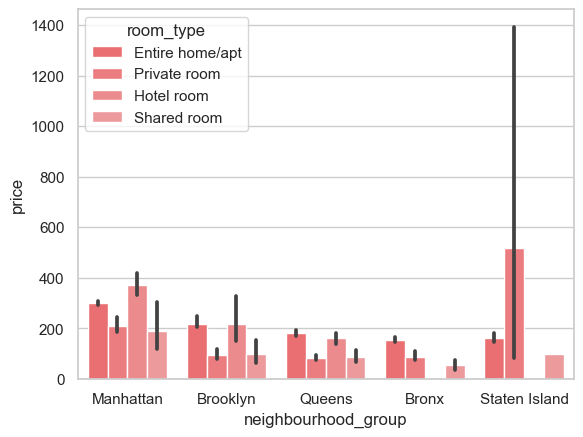

In [73]:
sns.barplot(x='neighbourhood_group', y ='price', hue = 'room_type', data = train_df)

In [74]:
train_df[train_df['neighbourhood_group']=='Staten Island']['price'].max()

65115

In [75]:
train_df[train_df['price']==65115]

id                                             name   host_id  \
9418  16289102  Comfy private room, great location to Manhattan  92493393   

     neighbourhood_group  neighbourhood     room_type  price  minimum_nights  \
9418       Staten Island  West Brighton  Private room  65115               2   

      number_of_reviews  reviews_per_month  ...  skiing lake  new  surf  \
9418                 55               0.72  ...       0    0    0     0   

     ext_opt_new  ext_opt_cnt  last_review_dt  last_review_year  room_type_le  \
9418                        0      2022-07-29            2022.0             2   

      have_price  
9418        True  

[1 rows x 31 columns]

In [76]:
type(train_df)

pandas.core.frame.DataFrame

In [77]:
train_df.groupby('room_type').agg({'price': ['mean', 'min', 'max'], 'id' : ['count']})

price                id
                       mean min    max  count
room_type                                    
Entire home/apt  249.260155  10  99000  24274
Hotel room       359.188235  99   1592    170
Private room     135.036592  10  85170  17873
Shared room      126.243478  15  10000    575

**Check 99% of the price range by room type**

In [78]:
for i in train_df["room_type"].unique():
    a = train_df.loc[df["room_type"] == i, "price"].quantile(0.99)
    print(f'quantile_price of { i} :  {a}')


quantile_price of Entire home/apt :  1478.8100000000013
quantile_price of Private room :  1008.3999999999942
quantile_price of Hotel room :  1321.5700000000006
quantile_price of Shared room :  1275.999999999999


`Note` I tried to remove outliers by dividing them by room type, but I changed it to the entire target and commented on the code

In [79]:
# # Assuming df_train is your DataFrame containing 'price' and 'room_type' columns

# def remove_outliers_by_quantile(df, quantile=0.9, groupby_column='room_type', value_column='price'):
#     def filter_outliers(group):
#         quantile_val = group[value_column].quantile(quantile)
#         return group[group[value_column] <= quantile_val]

#     filtered_df = df.groupby(groupby_column).apply(filter_outliers)
#     filtered_df.reset_index(drop=True, inplace=True)

#     return filtered_df

# # Applying the function to your DataFrame
# df_train_filtered = remove_outliers_by_quantile(train_df)

# # Now df_train_filtered contains the data with values within the 90th quantile of price by room_type


In [80]:
train_df.groupby('room_type')['price'].agg(['mean','min','max','std','var'])

mean  min    max          std           var
room_type                                                         
Entire home/apt  249.260155   10  99000   737.690299  5.441870e+05
Hotel room       359.188235   99   1592   275.584628  7.594689e+04
Private room     135.036592   10  85170  1081.075474  1.168724e+06
Shared room      126.243478   15  10000   497.519274  2.475254e+05

**Check Generated & Existing Columns**
- **id**
- **name**

- **host_id**
- **neighbourhood_group**
- **neighbourhood**
- **room_type**
- **price**
- **minimum_nights**
- **number_of_reviews**
- **reviews_per_month**
- **number_of_reviews_ltm**
- **last_review**
- **calculated_host_listings_count**
- **availability_365**
- **ext_opt**
- **gym**
- **pool**
- **view**
- **park**
- **new**
- **ext_opt_new**
- **ext_opt_cnt**
- **last_review_dt**
- **last_review_year**
- **room_type_le**
- **have_price**



In [81]:
train_df.columns

Index(['id', 'name', 'host_id', 'neighbourhood_group', 'neighbourhood',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'number_of_reviews_ltm', 'last_review',
       'calculated_host_listings_count', 'availability_365', 'ext_opt', 'gym',
       'pool', 'beach', 'view', 'park', 'camping', 'skiing', 'lake', 'new',
       'surf', 'ext_opt_new', 'ext_opt_cnt', 'last_review_dt',
       'last_review_year', 'room_type_le', 'have_price'],
      dtype='object')

In [82]:
train_df.head(2)

id                   name  host_id neighbourhood_group  \
0  2595  Skylit Midtown Castle     2845           Manhattan   
1  5121        BlissArtsSpace!     7356            Brooklyn   

        neighbourhood        room_type  price  minimum_nights  \
0             Midtown  Entire home/apt    150              30   
1  Bedford-Stuyvesant     Private room     60              30   

   number_of_reviews  reviews_per_month  ...  skiing lake  new  surf  \
0                 49                0.3  ...       0    0    0     0   
1                 50                0.3  ...       0    0    0     0   

  ext_opt_new  ext_opt_cnt  last_review_dt  last_review_year  room_type_le  \
0                        0      2022-06-21            2022.0             0   
1                        0      2019-12-02            2019.0             2   

   have_price  
0        True  
1        True  

[2 rows x 31 columns]

In [83]:
drop_column_list = ['last_review','last_review_dt','name', 'ext_opt']

In [84]:
train_df.drop(drop_column_list,axis = 1 ,inplace = True )

/var/folders/qm/t7nj8jrn23q1bgrhrz17cyhh0000gn/T/ipykernel_11056/1068166413.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(drop_column_list,axis = 1 ,inplace = True )


In [85]:
train_df

id    host_id neighbourhood_group       neighbourhood  \
0                    2595       2845           Manhattan             Midtown   
1                    5121       7356            Brooklyn  Bedford-Stuyvesant   
2                    5203       7490           Manhattan     Upper West Side   
3                    5178       8967           Manhattan             Midtown   
4                    5136       7378            Brooklyn         Sunset Park   
...                   ...        ...                 ...                 ...   
42926  839753193689829909   28057253            Brooklyn        Williamsburg   
42927  839786573617495393  247439246           Manhattan        East Village   
42928  839797749155954018   26349246            Brooklyn            Bushwick   
42929  839814083143454171   48533809       Staten Island         Bull's Head   
42930  839817199240589949  488616033            Brooklyn        Williamsburg   

             room_type  price  minimum_nights  number_of_reviews  \
0      Entire home/apt    150              30                 49   
1         Private room     60              30                 50   
2         Private room     75               2                118   
3         Private room     68               2                575   
4      Entire home/apt    275              60                  3   
...                ...    ...             ...                ...   
42926  Entire home/apt     76               7                  0   
42927     Private room     32              30                  0   
42928  Entire home/apt    127               3                  0   
42929  Entire home/apt    280               1                  0   
42930     Private room     78              90                  0   

       reviews_per_month  number_of_reviews_ltm  ...  camping  skiing  lake  \
0                   0.30                      1  ...        0       0     0   
1                   0.30                      0  ...        0       0     0   
2                   0.72                      0  ...        0       0     0   
3                   3.41                     52  ...        0       0     0   
4                   0.03                      1  ...        0       0     0   
...                  ...                    ...  ...      ...     ...   ...   
42926                NaN                      0  ...        0       0     0   
42927                NaN                      0  ...        0       0     0   
42928                NaN                      0  ...        0       0     0   
42929                NaN                      0  ...        0       0     0   
42930                NaN                      0  ...        0       0     0   

       new  surf  ext_opt_new  ext_opt_cnt  last_review_year  room_type_le  \
0        0     0                         0            2022.0             0   
1        0     0                         0            2019.0             2   
2        0     0                         0            2017.0             2   
3        0     0                         0            2023.0             2   
4        0     0                         0            2022.0             0   
...    ...   ...          ...          ...               ...           ...   
42926    0     0                         0               NaN             0   
42927    0     0      gym bbq            1               NaN             2   
42928    0     0                         0               NaN             0   
42929    0     0                         0               NaN             0   
42930    0     0                         0               NaN             2   

       have_price  
0            True  
1            True  
2            True  
3            True  
4            True  
...           ...  
42926        True  
42927        True  
42928        True  
42929        True  
42930        True  

[42892 rows x 27 columns]

In [86]:
train_df.columns

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'room_type',
       'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'number_of_reviews_ltm', 'calculated_host_listings_count',
       'availability_365', 'gym', 'pool', 'beach', 'view', 'park', 'camping',
       'skiing', 'lake', 'new', 'surf', 'ext_opt_new', 'ext_opt_cnt',
       'last_review_year', 'room_type_le', 'have_price'],
      dtype='object')

## 03. Remove Outliers

We tried to remove outliers based on quartiles.  
After removing outliers, we check correlation heatmap. 

In [87]:
from collections import Counter

def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step)|(df[col] > Q3 + outlier_step)].index

        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
        
    return multiple_outliers
        
Outliers_to_drop = detect_outliers(train_df, 0, ["price"])
final_train_df = train_df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


/var/folders/qm/t7nj8jrn23q1bgrhrz17cyhh0000gn/T/ipykernel_11056/4221377401.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = final_train_df[final_use_column].corr().round(2)


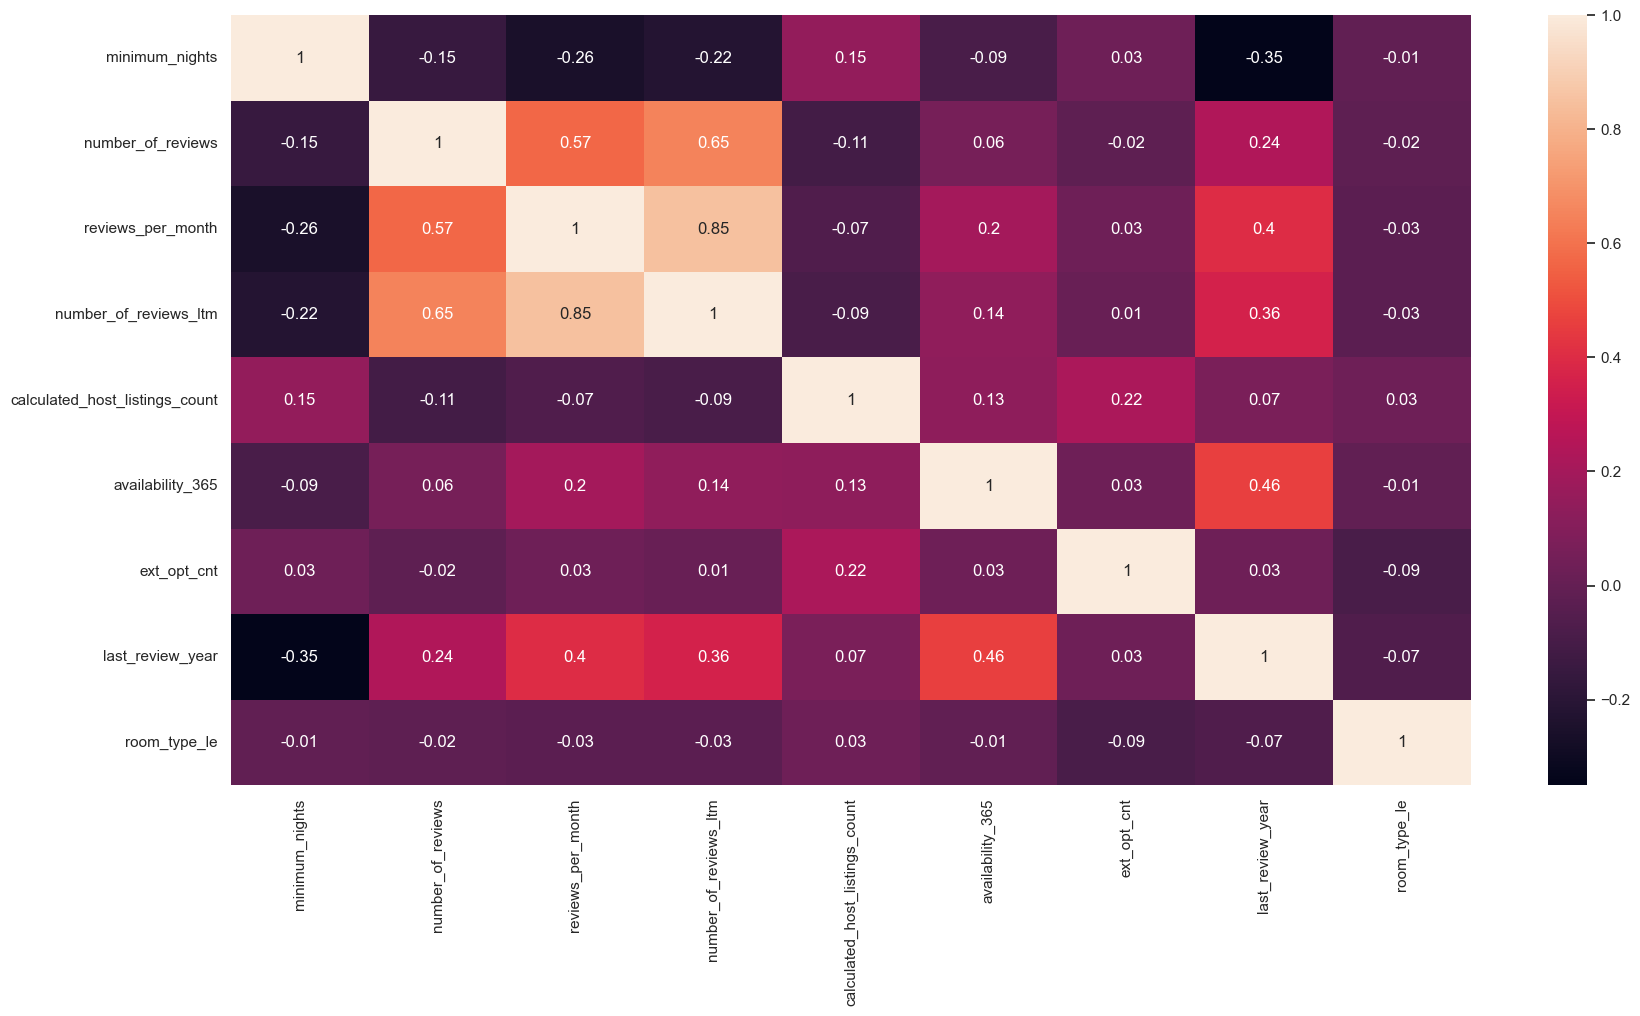

In [88]:
# We do not check feature importance for low frequency columns.
final_use_column = [ 'neighbourhood_group', 'neighbourhood', 'room_type',
                     'minimum_nights', 'number_of_reviews', 'reviews_per_month',
                     'number_of_reviews_ltm', 'calculated_host_listings_count',
                     'availability_365', 'ext_opt_new', 'ext_opt_cnt',
                     # 'gym', 'pool', 'view', 'park',
                     # 'new', 'host_id', 'have_price',
                     'last_review_year', 'room_type_le']

# Create a correlation matrix
# Show up to the second decimal place
correlation_matrix = final_train_df[final_use_column].corr().round(2)

# Specifying Image Size
plt.figure(figsize=(20,10))

# Show Correlation Matrix
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

In [89]:
final_train_df.columns

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'room_type',
       'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'number_of_reviews_ltm', 'calculated_host_listings_count',
       'availability_365', 'gym', 'pool', 'beach', 'view', 'park', 'camping',
       'skiing', 'lake', 'new', 'surf', 'ext_opt_new', 'ext_opt_cnt',
       'last_review_year', 'room_type_le', 'have_price'],
      dtype='object')

In [90]:
columns = final_train_df.columns

for c in columns :
    
    null_cnt = final_train_df[final_train_df[c].isnull()].count()['host_id']
    whole_cnt = final_train_df['host_id'].count()
    print( f"{c}Ïùò null ÎπÑÏú® { round(null_cnt / whole_cnt,4) * 100} %" )


idÏùò null ÎπÑÏú® 0.0 %
host_idÏùò null ÎπÑÏú® 0.0 %
neighbourhood_groupÏùò null ÎπÑÏú® 0.0 %
neighbourhoodÏùò null ÎπÑÏú® 0.0 %
room_typeÏùò null ÎπÑÏú® 0.0 %
priceÏùò null ÎπÑÏú® 0.0 %
minimum_nightsÏùò null ÎπÑÏú® 0.0 %
number_of_reviewsÏùò null ÎπÑÏú® 0.0 %
reviews_per_monthÏùò null ÎπÑÏú® 22.21 %
number_of_reviews_ltmÏùò null ÎπÑÏú® 0.0 %
calculated_host_listings_countÏùò null ÎπÑÏú® 0.0 %
availability_365Ïùò null ÎπÑÏú® 0.0 %
gymÏùò null ÎπÑÏú® 0.0 %
poolÏùò null ÎπÑÏú® 0.0 %
beachÏùò null ÎπÑÏú® 0.0 %
viewÏùò null ÎπÑÏú® 0.0 %
parkÏùò null ÎπÑÏú® 0.0 %
campingÏùò null ÎπÑÏú® 0.0 %
skiingÏùò null ÎπÑÏú® 0.0 %
lakeÏùò null ÎπÑÏú® 0.0 %
newÏùò null ÎπÑÏú® 0.0 %
surfÏùò null ÎπÑÏú® 0.0 %
ext_opt_newÏùò null ÎπÑÏú® 0.0 %
ext_opt_cntÏùò null ÎπÑÏú® 0.0 %
last_review_yearÏùò null ÎπÑÏú® 22.21 %
room_type_leÏùò null ÎπÑÏú® 0.0 %
have_priceÏùò null ÎπÑÏú® 0.0 %


In [91]:
final_train_df['last_review_year'].fillna(0, inplace = True)
final_train_df['reviews_per_month'].fillna(0, inplace = True)

In [92]:
used_cat_boosting_columns = ['host_id', 'neighbourhood_group', 'room_type', 'neighbourhood',
       'price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count',
       'availability_365','ext_opt_new', 'ext_opt_cnt', 'last_review_year']

used_boosting_columns = [ 'host_id', 'neighbourhood_group', 'room_type',
       'price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count',
       'availability_365', 'gym', 'pool', 'view', 'park',
       'new',  'ext_opt_cnt','last_review_year']

In [93]:
# categorical variable dummyization
boosting_df = final_train_df[used_boosting_columns]
boosting_df = pd.get_dummies(boosting_df)

In [94]:
boosting_df.shape
boosting_df.columns[:100]

Index(['host_id', 'price', 'minimum_nights', 'number_of_reviews',
       'calculated_host_listings_count', 'availability_365', 'gym', 'pool',
       'view', 'park', 'new', 'ext_opt_cnt', 'last_review_year',
       'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten Island', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room'],
      dtype='object')

In [95]:
# categorical variable dummyization
cat_boosting_df = final_train_df[used_cat_boosting_columns]
cat_boosting_df.to_csv('airbnb_preprocessing_data_for_cat.csv',index=False)


In [96]:
# save data for modeling
boosting_df.to_csv('airbnb_preprocessing_data.csv',index=False)